# Eliminating Trend and Seasonality

## Objectives

* Remove non-stationarity of complex time-series with high seasonality.
* Use Differencing and Decomposition techniques for making time-series stationary. 
* Compare the effectiveness of differencing vs. decomposition. 

## Introduction

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality for such time-series. 

* **Differencing** – taking the differece with a particular time lag
* **Decomposition** – modeling both trend and seasonality and removing them from the model.

Let's once again import the passengers dataset and the `stationarity_check()` function from previous to apply these techniques and monitor the effect. 


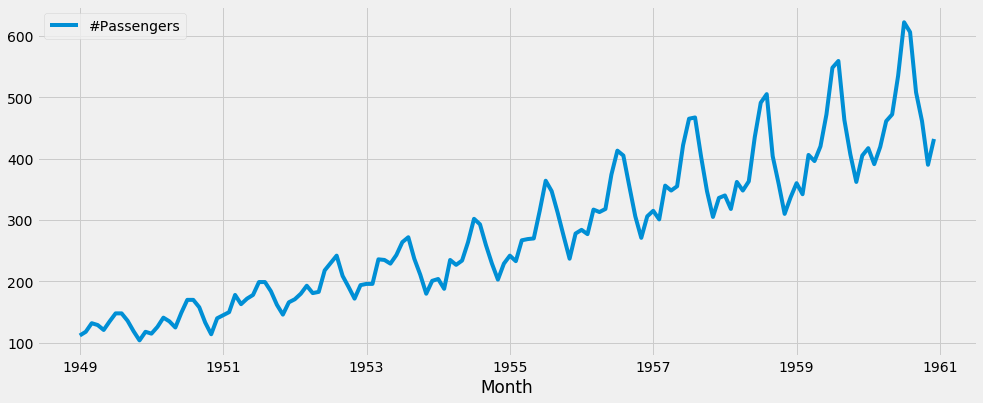

In [4]:
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Import adfuller
from statsmodels.tsa.stattools import adfuller

# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window=12).mean() # Change window size for different lags
    rolstd = TS.rolling(window=12).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['#Passengers'], autolag='AIC') # change the passengers column as required 
    
    #Plot rolling statistics:
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

# Import passengers.csv and set it as a time-series object. Plot the TS
data = pd.read_csv('passengers.csv')
ts = data.set_index('Month')
ts.index = pd.to_datetime(ts.index)
ts.plot()   


## Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant (i.e. Lag).  This mostly works well in improving stationarity. First order differencing can be done in Pandas using the `shift()` function to shift the values in the index by a specified number of units of the index's period. Details of `.shift()` can be viewed [HERE](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html).

1. Take the log of ts. 
2. Apply `shift()` to the output of 1. Use period of 1 (set by default)
3. subtract result of 2 from 1.
4. Plot the resulting time-series

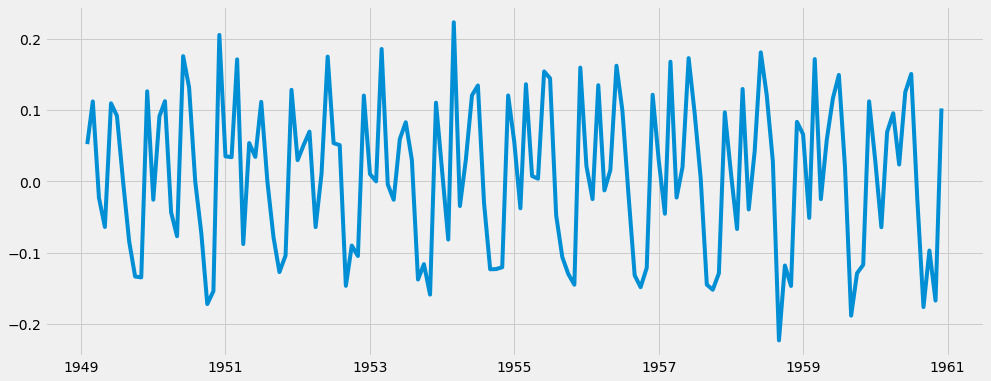

In [5]:
# Calculate the difference of log transformed ts with shifted log transformed ts and plot.
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()

rcParams['figure.figsize'] = 15, 6
plt.plot(ts_log_diff)

This appears to have reduced trend considerably. Lets verify if this actually worked. First drop the NaN values and then use `stationarity_check()` function. 

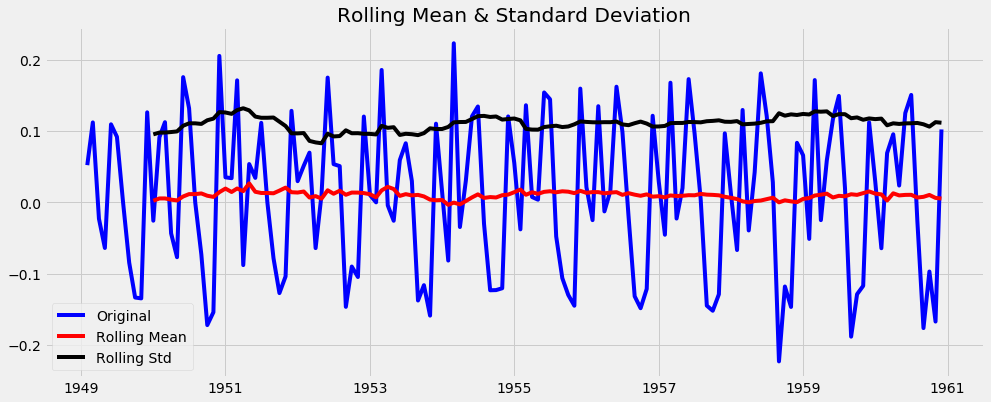

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [6]:
# Drop NANs and check for stationarity
ts_log_diff.dropna(inplace=True)
stationarity_check(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications. 

> **BONUS EXERCISE** Use second and third order differencing with `shift()` and compare the results. 

## Decomposing

Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

>Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.

>Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.

>Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

### Additive or Multiplicative Decomposition?

To achieve successful decomposition, it is important to choose between the additive and multiplicative models, which requires analyzing the series. For example, does the magnitude of the seasonality increase when the time series increases?

![](http://kourentzes.com/forecasting/wp-content/uploads/2014/11/mseas.fig1_.png)


Fortunately, `statsmodels` provides the convenient `seasonal_decompose` function to perform such decomposition out of the box. Details of this function are available [HERE](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). 

Let's use this function to perform following tasks:
1. Import `seasonal_decompose` from statsmodels.
2. Apply `seasonal_decompose` to log transformed TS. 
3. Plot the trend, seasonality and residual. 

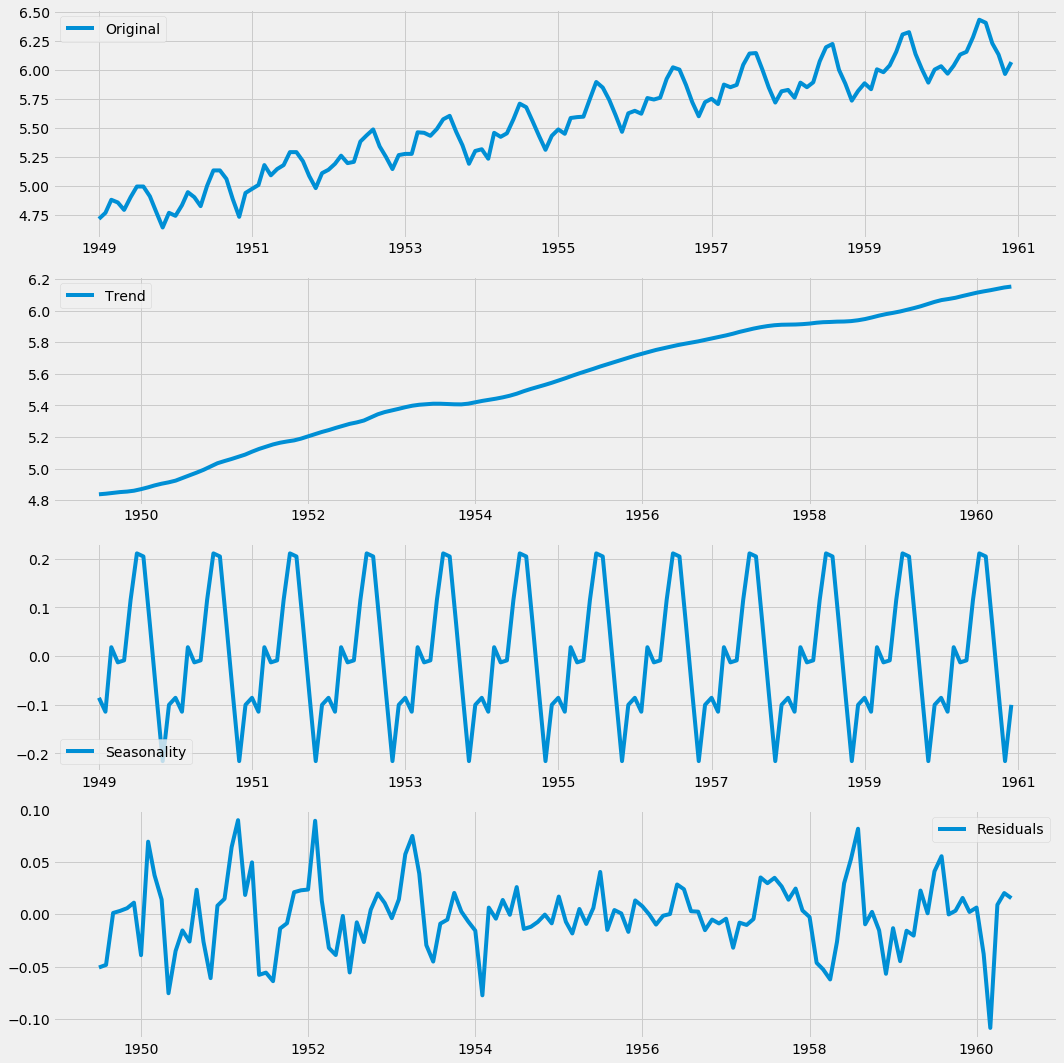

In [7]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
rcParams['figure.figsize'] = 15, 15
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals.

Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

Lets check stationarity of residuals using our `check_stationarity()` function.

NOTE: drop NaN values first. 

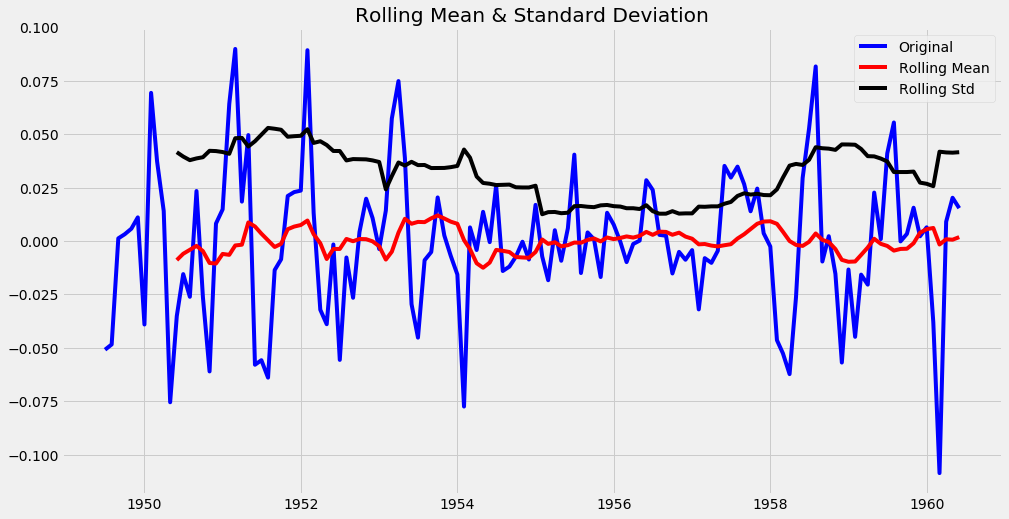

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [8]:
# Drop NaN values from residuals.
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

# Check stationarity
rcParams['figure.figsize'] = 15, 8
stationarity_check(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. We can try more advanced decomposition techniques as well which can generate better results.

## Summary: 
In this lesson, we saw how to remove both trend and seasonality from a time-series using differencing and decomposition. We saw how decmoposition allows us to better model the time-series for further analysis. After these steps, we can perform predictive analyses and modelling with time-series data which will be covered in following lab. 